<a href="https://colab.research.google.com/github/mrcaelumn/Enchanted_Matrix_Factorization/blob/main/Matrix_Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet --upgrade cachetools~=3.1
!pip install --quiet --upgrade portpicker
!pip install --quiet --upgrade scipy~=1.7.1
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.1.2 requires cachetools>=4.2.1, but you have cachetools 3.1.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires portpicker~=1.3.1, but you have portpicker 1.5.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.8/39.8 MB 9.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.1.2 requires cachetools>=4.2.1, but you have cachetools 3.1.1 which is incompatible.
arviz 0.15.1 requires scipy>=1.8.0, but you have scipy 1.7.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import collections
import functools
import io
import os
import requests
import zipfile
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(42)

In [3]:
def download_movielens_data(dataset_path):
  """Downloads and copies MovieLens data to local /tmp directory."""
  if dataset_path.startswith('http'):
    r = requests.get(dataset_path)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path='tmp')
  else:
    tf.io.gfile.makedirs('tmp/ml-1m/')
    for filename in ['ratings.dat', 'movies.dat', 'users.dat']:
      tf.io.gfile.copy(
          os.path.join(dataset_path, filename),
          os.path.join('tmp/ml-1m/', filename),
          overwrite=True)

download_movielens_data('http://files.grouplens.org/datasets/movielens/ml-1m.zip')

In [4]:
from io import StringIO
def load_movielens_data(
    data_directory: str = "tmp",
) -> Tuple[pd.DataFrame, pd.DataFrame]:
  """Loads pandas DataFrames for ratings, movies, users from data directory."""
  # Load pandas DataFrames from data directory. Assuming data is formatted as
  # specified in http://files.grouplens.org/datasets/movielens/ml-1m-README.txt.

  ratings_file = pd.read_csv(os.path.join(data_directory, "ml-1m", "ratings.dat"), sep='::', engine="python", na_values="NA", encoding="ISO-8859-1")
  ratings_file.to_csv (os.path.join(data_directory, "ml-1m", "ratings.csv"), index=None)

  movies_file = pd.read_csv(os.path.join(data_directory, "ml-1m", "movies.dat"), sep='::', engine="python", na_values="NA", encoding="ISO-8859-1")
  movies_file.to_csv (os.path.join(data_directory, "ml-1m", "movies.csv"), index=None)


  ratings_df = pd.read_csv(
      os.path.join(data_directory, "ml-1m", "ratings.csv"),
      sep=",",
      names=["UserID", "MovieID", "Rating", "Timestamp"], engine="python", encoding="utf-8")
  movies_df = pd.read_csv(
      os.path.join(data_directory, "ml-1m", "movies.csv"),
      sep=",",
      names=["MovieID", "Title", "Genres"], engine="python", encoding="utf-8")

  # Create dictionaries mapping from old IDs to new (remapped) IDs for both
  # MovieID and UserID. Use the movies and users present in ratings_df to
  # determine the mapping, since movies and users without ratings are unneeded.
  # print(ratings_df)
  movie_mapping = {
      old_movie: new_movie for new_movie, old_movie in enumerate(
          ratings_df.MovieID.astype("category").cat.categories)
  }
  user_mapping = {
      old_user: new_user for new_user, old_user in enumerate(
          ratings_df.UserID.astype("category").cat.categories)
  }

  # Map each DataFrame consistently using the now-fixed mapping.
  ratings_df.MovieID = ratings_df.MovieID.map(movie_mapping)
  ratings_df.UserID = ratings_df.UserID.map(user_mapping)
  movies_df.MovieID = movies_df.MovieID.map(movie_mapping)

  # Remove nulls resulting from some movies being in movies_df but not
  # ratings_df.
  movies_df = movies_df[pd.notnull(movies_df.MovieID)]

  return ratings_df, movies_df

In [5]:
ratings_df, movies_df = load_movielens_data()

In [6]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3177,4,978300275
4,0,2162,5,978824291


In [7]:
movies_df.head()

,MovieID,Title,Genres
0,0.0,Toy Story (1995),Animation|Children's|Comedy
1,1.0,Jumanji (1995),Adventure|Children's|Fantasy
2,2.0,Grumpier Old Men (1995),Comedy|Romance
3,3.0,Waiting to Exhale (1995),Comedy|Drama
4,4.0,Father of the Bride Part II (1995),Comedy


In [8]:
print('Num users:', len(set(ratings_df.UserID)))
print('Num movies:', len(set(ratings_df.MovieID)))

Num users: 6040
Num movies: 3706


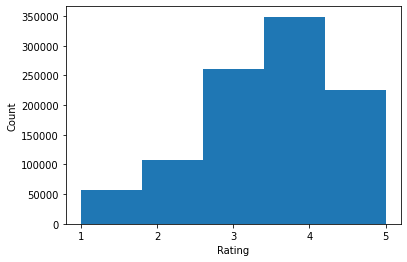

Average rating: 3.581564453029317
Median rating: 4.0


In [9]:
ratings = ratings_df.Rating.tolist()

plt.hist(ratings, bins=5)
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel('Count')
plt.xlabel('Rating')
plt.show()

print('Average rating:', np.mean(ratings))
print('Median rating:', np.median(ratings))

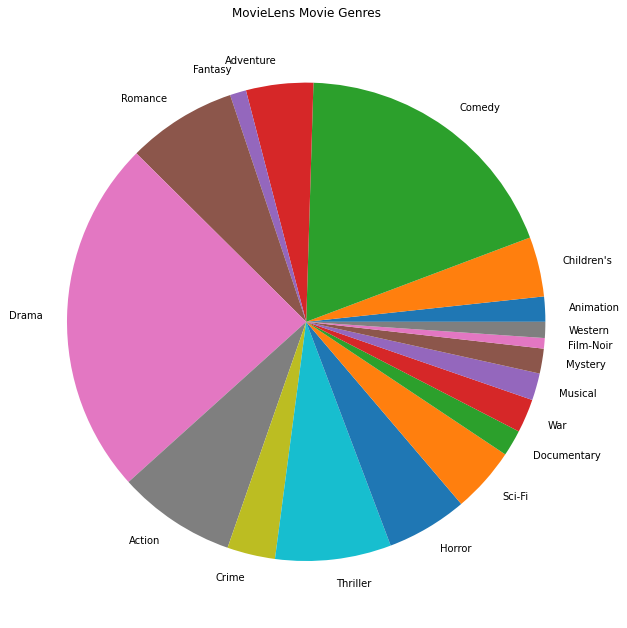

In [10]:
movie_genres_list = movies_df.Genres.tolist()
# Count the number of times each genre describes a movie.
genre_count = collections.defaultdict(int)
for genres in movie_genres_list:
  curr_genres_list = genres.split('|')
  for genre in curr_genres_list:
    genre_count[genre] += 1
genre_name_list, genre_count_list = zip(*genre_count.items())

plt.figure(figsize=(11, 11))
plt.pie(genre_count_list, labels=genre_name_list)
plt.title('MovieLens Movie Genres')
plt.show()

In [11]:
def print_top_genres_for_user(ratings_df, movies_df, user_id):
  """Prints top movie genres for user with ID user_id."""
  user_ratings_df = ratings_df[ratings_df.UserID == user_id]
  movie_ids = user_ratings_df.MovieID

  genre_count = collections.Counter()
  for movie_id in movie_ids:
    genres_string = movies_df[movies_df.MovieID == movie_id].Genres.tolist()[0]
    for genre in genres_string.split('|'):
      genre_count[genre] += 1

  print(f'\nFor user {user_id}:')
  for (genre, freq) in genre_count.most_common(5):
    print(f'{genre} was rated {freq} times')

print_top_genres_for_user(ratings_df, movies_df, user_id=0)
print_top_genres_for_user(ratings_df, movies_df, user_id=10)
print_top_genres_for_user(ratings_df, movies_df, user_id=19)


For user 0:
Drama was rated 21 times
Children's was rated 20 times
Animation was rated 18 times
Musical was rated 14 times
Comedy was rated 14 times

For user 10:
Comedy was rated 84 times
Drama was rated 54 times
Romance was rated 22 times
Thriller was rated 18 times
Action was rated 9 times

For user 19:
Action was rated 17 times
Sci-Fi was rated 9 times
Thriller was rated 9 times
Drama was rated 6 times
Crime was rated 5 times


In [12]:
def create_tf_datasets(ratings_df: pd.DataFrame,
                       batch_size: int = 1,
                       max_examples_per_user: Optional[int] = None,
                       max_clients: Optional[int] = None) -> List[tf.data.Dataset]:
  """Creates TF Datasets containing the movies and ratings for all users."""
  num_users = len(set(ratings_df.UserID))
  # Optionally limit to `max_clients` to speed up data loading.
  if max_clients is not None:
    num_users = min(num_users, max_clients)

  def rating_batch_map_fn(rating_batch):
    """Maps a rating batch to an OrderedDict with tensor values."""
    # Each example looks like: {x: movie_id, y: rating}.
    # We won't need the UserID since each client will only look at their own
    # data.
    return collections.OrderedDict([
        ("x", tf.cast(rating_batch[:, 1:2], tf.int64)),
        ("y", tf.cast(rating_batch[:, 2:3], tf.float32))
    ])

  tf_datasets = []
  for user_id in range(num_users):
    # Get subset of ratings_df belonging to a particular user.
    user_ratings_df = ratings_df[ratings_df.UserID == user_id]

    tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings_df)

    # Define preprocessing operations.
    tf_dataset = tf_dataset.take(max_examples_per_user).shuffle(
        buffer_size=max_examples_per_user, seed=42).batch(batch_size).map(
        rating_batch_map_fn,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    tf_datasets.append(tf_dataset)

  return tf_datasets


def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset], List[tf.data.Dataset]]:
  """Splits a list of user TF datasets into train/val/test by user.
  """
  np.random.seed(42)
  np.random.shuffle(tf_datasets)

  train_idx = int(len(tf_datasets) * train_fraction)
  val_idx = int(len(tf_datasets) * (train_fraction + val_fraction))

  # Note that the val and test data contains completely different users, not
  # just unseen ratings from train users.
  return (tf_datasets[:train_idx], tf_datasets[train_idx:val_idx],
          tf_datasets[val_idx:])

In [13]:
# We limit the number of clients to speed up dataset creation. Feel free to pass
# max_clients=None to load all clients' data.
tf_datasets = create_tf_datasets(
    ratings_df=ratings_df,
    batch_size=5,
    max_examples_per_user=300,
    max_clients=2000)

# Split the ratings into training/val/test by client.
tf_train_datasets, tf_val_datasets, tf_test_datasets = split_tf_datasets(
    tf_datasets,
    train_fraction=0.8,
    val_fraction=0.1)

In [14]:
print(next(iter(tf_train_datasets[0])))

OrderedDict([('x', <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1907],
       [2891],
       [1574],
       [2785],
       [2775]])>), ('y', <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[3.],
       [3.],
       [3.],
       [4.],
       [3.]], dtype=float32)>)])


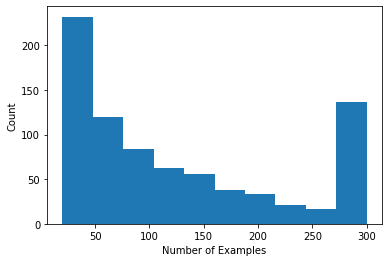

In [15]:
def count_examples(curr_count, batch):
  return curr_count + tf.size(batch['x'])

num_examples_list = []
# Compute number of examples for every other user.
for i in range(0, len(tf_train_datasets), 2):
  num_examples = tf_train_datasets[i].reduce(tf.constant(0), count_examples).numpy()
  num_examples_list.append(num_examples)

plt.hist(num_examples_list, bins=10)
plt.ylabel('Count')
plt.xlabel('Number of Examples')
plt.show()

In [16]:
class UserEmbedding(tf.keras.layers.Layer):
  """Keras layer representing an embedding for a single user, used below."""

  def __init__(self, num_latent_factors, **kwargs):
    super().__init__(**kwargs)
    self.num_latent_factors = num_latent_factors

  def build(self, input_shape):
    self.embedding = self.add_weight(
        shape=(1, self.num_latent_factors),
        initializer='uniform',
        dtype=tf.float32,
        name='UserEmbeddingKernel')
    super().build(input_shape)

  def call(self, inputs):
    return self.embedding

  def compute_output_shape(self):
    return (1, self.num_latent_factors)


def get_matrix_factorization_model(
    num_items: int,
    num_latent_factors: int) -> tff.learning.reconstruction.Model:
  """Defines a Keras matrix factorization model."""
  # Layers with variables will be partitioned into global and local layers.
  # We'll pass this to `tff.learning.reconstruction.from_keras_model`.
  global_layers = []
  local_layers = []

  # Extract the item embedding.
  item_input = tf.keras.layers.Input(shape=[1], name='Item')
  item_embedding_layer = tf.keras.layers.Embedding(
      num_items,
      num_latent_factors,
      name='ItemEmbedding')
  global_layers.append(item_embedding_layer)
  flat_item_vec = tf.keras.layers.Flatten(name='FlattenItems')(
      item_embedding_layer(item_input))

  # Extract the user embedding.
  user_embedding_layer = UserEmbedding(
      num_latent_factors,
      name='UserEmbedding')
  local_layers.append(user_embedding_layer)

  # The item_input never gets used by the user embedding layer,
  # but this allows the model to directly use the user embedding.
  flat_user_vec = user_embedding_layer(item_input)

  # Compute the dot product between the user embedding, and the item one.
  pred = tf.keras.layers.Dot(
      1, normalize=False, name='Dot')([flat_user_vec, flat_item_vec])

  input_spec = collections.OrderedDict(
      x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
      y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32))

  model = tf.keras.Model(inputs=item_input, outputs=pred)

  return tff.learning.reconstruction.from_keras_model(
      keras_model=model,
      global_layers=global_layers,
      local_layers=local_layers,
      input_spec=input_spec)

In [17]:
# This will be used to produce our training process.
# User and item embeddings will be 50-dimensional.
model_fn = functools.partial(
    get_matrix_factorization_model,
    num_items=3706,
    num_latent_factors=50)

In [18]:
class RatingAccuracy(tf.keras.metrics.Mean):
  """Keras metric computing accuracy of reconstructed ratings."""

  def __init__(self,
               name: str = 'rating_accuracy',
               **kwargs):
    super().__init__(name=name, **kwargs)

  def update_state(self,
                   y_true: tf.Tensor,
                   y_pred: tf.Tensor,
                   sample_weight: Optional[tf.Tensor] = None):
    absolute_diffs = tf.abs(y_true - y_pred)
    # A [batch_size, 1] tf.bool tensor indicating correctness within the
    # threshold for each example in a batch. A 0.5 threshold corresponds
    # to correctness when predictions are rounded to the nearest whole
    # number.
    example_accuracies = tf.less_equal(absolute_diffs, 0.5)
    super().update_state(example_accuracies, sample_weight=sample_weight)


loss_fn = lambda: tf.keras.losses.MeanSquaredError()
metrics_fn = lambda: [RatingAccuracy()]

In [19]:
# Apply Gradient Centralization, able both speedup training process and improve the final generalization performance of DNNs.
# It operates directly on gradients by centralizing the gradient vectors to have zero mean. 
class GCSGD(tf.keras.optimizers.SGD):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads

In [20]:
# We'll use this by doing:
# state = training_process.initialize()
# state, metrics = training_process.next(state, federated_train_data)
training_process = tff.learning.reconstruction.build_training_process(
    model_fn=model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    server_optimizer_fn=lambda: GCSGD(1.0),
    client_optimizer_fn=lambda: GCSGD(0.5),
    reconstruction_optimizer_fn=lambda: GCSGD(0.1))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
# We'll use this by doing:
# eval_metrics = evaluation_computation(state.model, tf_val_datasets)
# where `state` is the state from the training process above.
evaluation_computation = tff.learning.reconstruction.build_federated_evaluation(
    model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    reconstruction_optimizer_fn=functools.partial(
            GCSGD, 0.1))

In [22]:
state = training_process.initialize()
print(training_process.model)
print('Item variables shape:', training_process.model.trainable[0].shape)

UnsupportedOperation: ignored

In [23]:
# We shouldn't expect good evaluation results here, since we haven't trained
# yet!
eval_metrics = evaluation_computation(state.model, tf_val_datasets)
print('Initial Eval:', eval_metrics['eval'])

NameError: ignored

In [ ]:
federated_train_data = np.random.choice(tf_train_datasets, size=50, replace=False).tolist()
state, metrics = training_process.next(state, federated_train_data)
print(f'Train metrics:', metrics['train'])

In [ ]:
NUM_ROUNDS = 20

train_losses = []
train_accs = []

state = training_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
  federated_train_data = np.random.choice(tf_train_datasets, size=50, replace=False).tolist()
  state, metrics = training_process.next(state, federated_train_data)
  print(f'Train round {i}:', metrics['train'])
  train_losses.append(metrics['train']['loss'])
  train_accs.append(metrics['train']['rating_accuracy'])


eval_metrics = evaluation_computation(state.model, tf_val_datasets)
print('Final Eval:', eval_metrics['eval'])

In [ ]:
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel('Train Loss')
plt.xlabel('Round')
plt.title('Train Loss')
plt.show()

plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel('Train Accuracy')
plt.xlabel('Round')
plt.title('Train Accuracy')
plt.show()

In [ ]:
eval_metrics = evaluation_computation(state.model, tf_test_datasets)
print('Final Test:', eval_metrics['eval'])
